# Introduction

The notebook is intended to analyse the weather outside conditions to find correlations with the inside air pollutions.

[Data](https://opendata.swiss/en/dataset/stundlich-aktualisierte-meteodaten-seit-1992)

In [57]:
# Import Standard Libraries
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

import seaborn as sns

In [20]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [59]:
# Notebook's variables
weather_2022_data_file = './../data/ugz_ogd_meteo_h1_2022.csv'
sensirion_data_file = './../data/20220915_HackZurich_Sensirion_v1.csv'

# Read Data

In [67]:
# Read precipitation data
weather_2022_data = pd.read_csv(weather_2022_data_file,
                                parse_dates=['Datum'])

sensirion_data = pd.read_csv(sensirion_data_file, 
                             parse_dates=['Unnamed: 0'])

# Rename columns
sensirion_data.columns = ['Datum'] + sensirion_data.columns[0:].tolist()

ValueError: Length mismatch: Expected axis has 31 elements, new values have 32 elements

In [69]:
sensirion_data.columns[0:].ge

AttributeError: 'Index' object has no attribute 'items'

In [64]:
weather_2022_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype                               
---  ------     --------------   -----                               
 0   Datum      136950 non-null  datetime64[ns, pytz.FixedOffset(60)]
 1   Standort   136950 non-null  object                              
 2   Parameter  136950 non-null  object                              
 3   Intervall  136950 non-null  object                              
 4   Einheit    136950 non-null  object                              
 5   Wert       136476 non-null  float64                             
 6   Status     136950 non-null  object                              
dtypes: datetime64[ns, pytz.FixedOffset(60)](1), float64(1), object(5)
memory usage: 7.3+ MB


In [65]:
sensirion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69985 entries, 0 to 69984
Data columns (total 31 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   DatumUnnamed: 0                                             69985 non-null  datetime64[ns]
 1   Datumtemperature_ventilation_system_fresh_air_in            50974 non-null  float64       
 2   Datumtemperature_ventilation_system_fresh_air_intermediate  50974 non-null  float64       
 3   Datumtemperature_ventilation_system_fresh_air_out           50974 non-null  float64       
 4   Datumtemperature_ventilation_system_used_air_in             50974 non-null  float64       
 5   Datumtemperature_ventilation_system_used_air_out            50974 non-null  float64       
 6   Datumvolumne_flow_ventitaltion_system_in                    50974 non-null  float64       
 7   Datumparticulate_matte

In [24]:
weather_2022_data.head()

,Datum,Standort,Parameter,Intervall,Einheit,Wert,Status
0,2022-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,T,h1,°C,7.22,provisorisch
1,2022-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,Hr,h1,%Hr,82.93,provisorisch
2,2022-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,p,h1,hPa,977.20,provisorisch
3,2022-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,RainDur,h1,min,0.00,provisorisch
4,2022-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.02,provisorisch


# Exploratory Data Analysis

## NaN Values

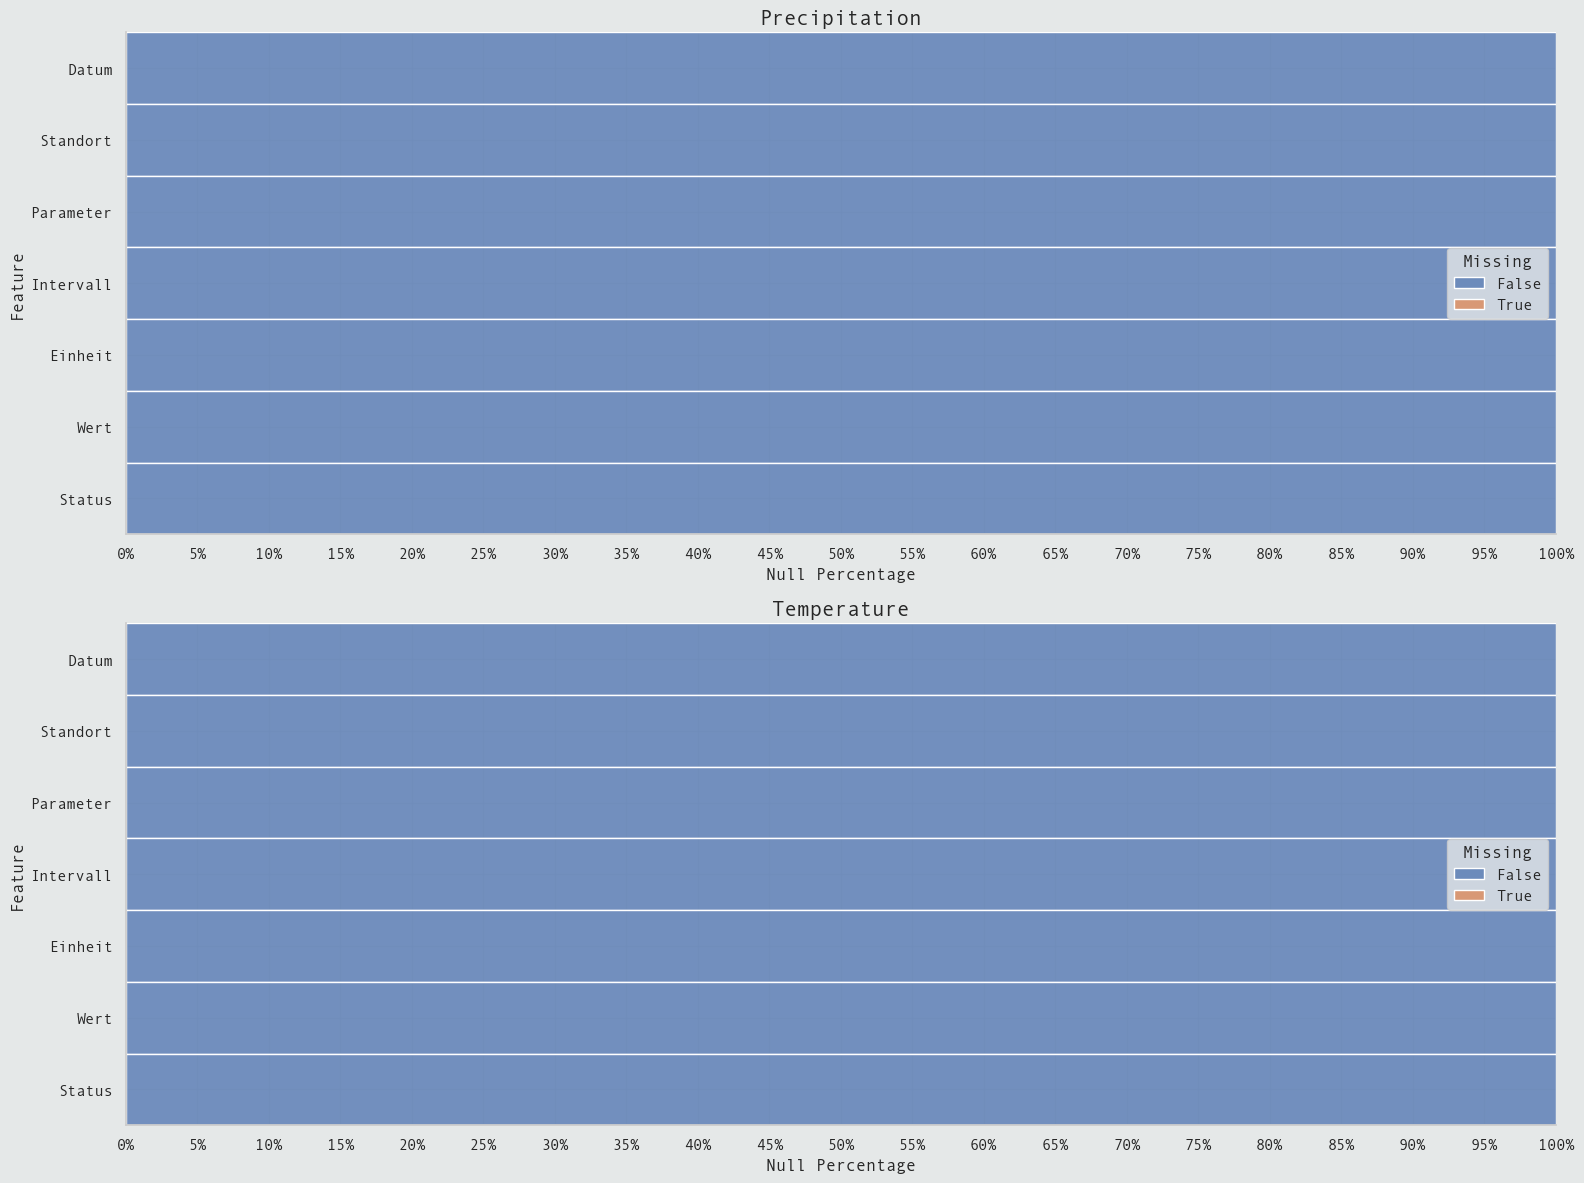

In [58]:
# Define data to display
data_to_display = {
    'Precipitation': weather_2022_data[weather_2022_data['Parameter'] == 'RainDur'],
    'Temperature': weather_2022_data[weather_2022_data['Parameter'] == 'T']
}

# Create figure
figure = plt.figure(tight_layout=True, figsize=(16, 12))

# Define figure's subplots
grid_spec = GridSpec(len(data_to_display), 1)

# Fetch data to plot
for row, (name, dataframe) in enumerate(data_to_display.items()):
    
    # Create subplot
    ax = figure.add_subplot(grid_spec[row, 0])
    
    sns.histplot(data=dataframe.isna().melt(var_name='Feature', value_name='Missing'), 
                 y='Feature', 
                 hue='Missing', 
                 multiple='fill',
                 ax=ax)
    
    # Refactor x label as missing percentage
    ax.xaxis.set_major_locator(ticker.LinearLocator(21))
    ax.xaxis.set_major_formatter('{:.0%}'.format)
    
    # Set title and label
    ax.set_title(name, fontsize=15)
    ax.set_xlabel('Null Percentage')

## Precipitations over Time

In [25]:
# Retrieve only precipitations
precipitations_2022 = weather_2022_data[weather_2022_data['Parameter'] == 'RainDur']

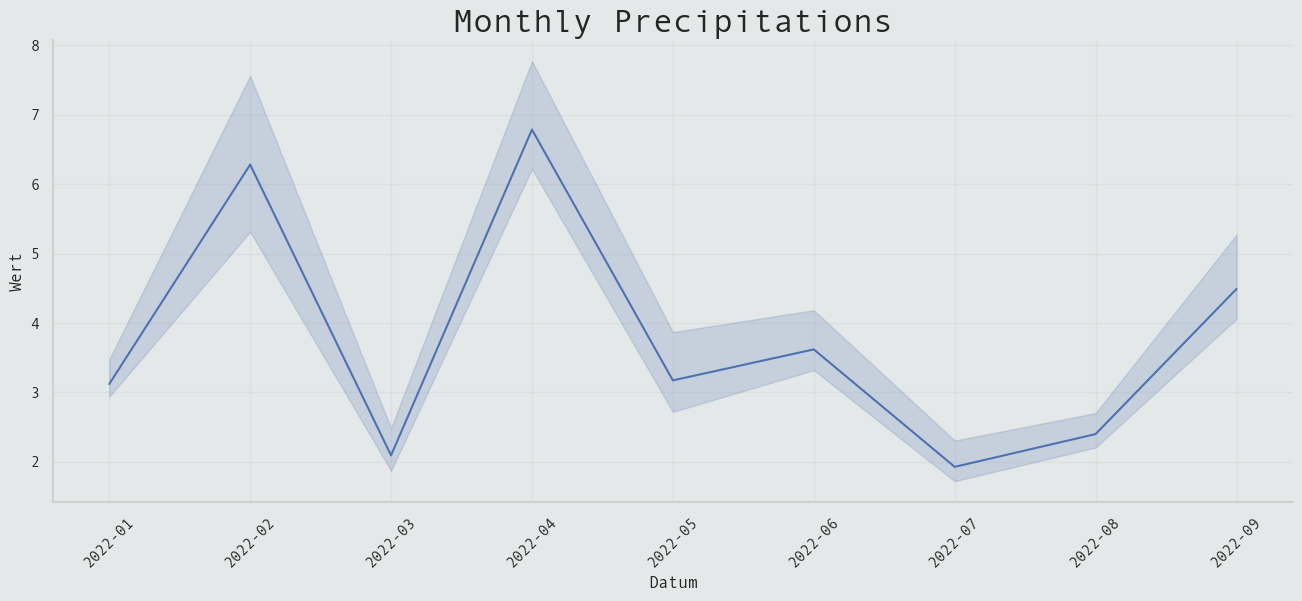

In [44]:
ax = sns.lineplot(
    data=precipitations_2022.groupby([
        precipitations_2022.Datum.dt.strftime('%Y-%m'),
        precipitations_2022.Standort
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert'
)

ax.set_title('Monthly Precipitations')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.show()

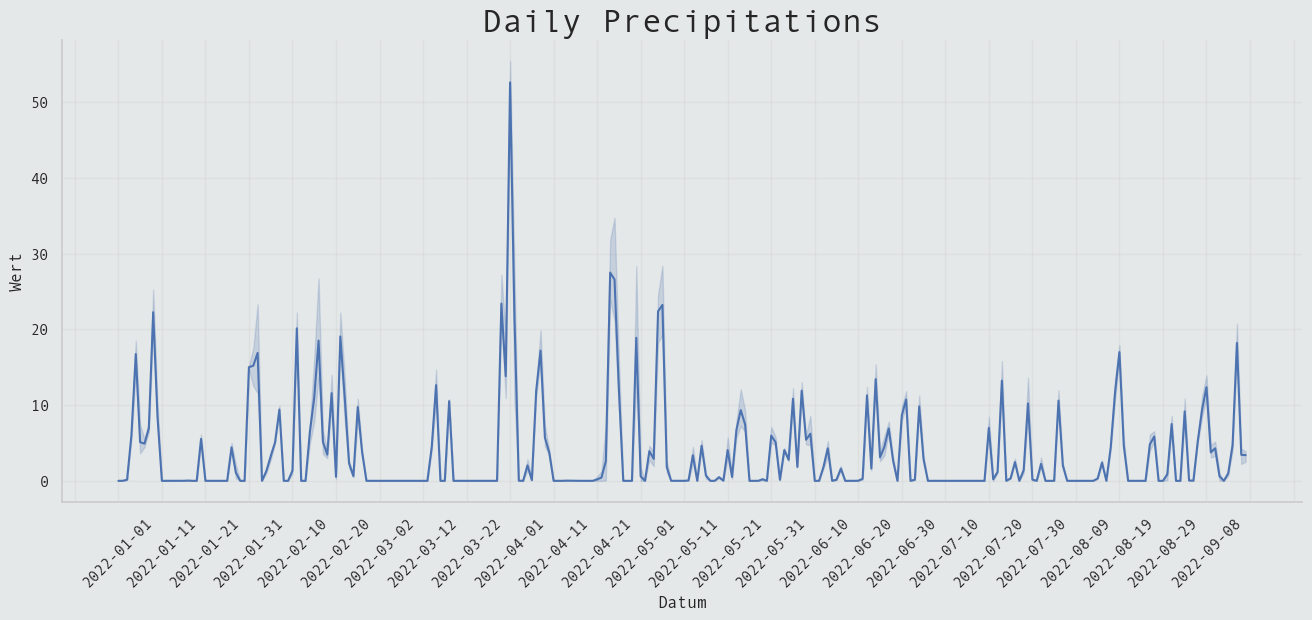

In [46]:
ax = sns.lineplot(
    data=precipitations_2022.groupby([
        precipitations_2022.Datum.dt.strftime('%Y-%m-%d'),
        precipitations_2022.Standort
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert'
)

ax.set_title('Daily Precipitations')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))

plt.show()

## Temperature over Time

In [33]:
# Retrieve only temperatures
temperatures_2022 = weather_2022_data[weather_2022_data['Parameter'] == 'T']

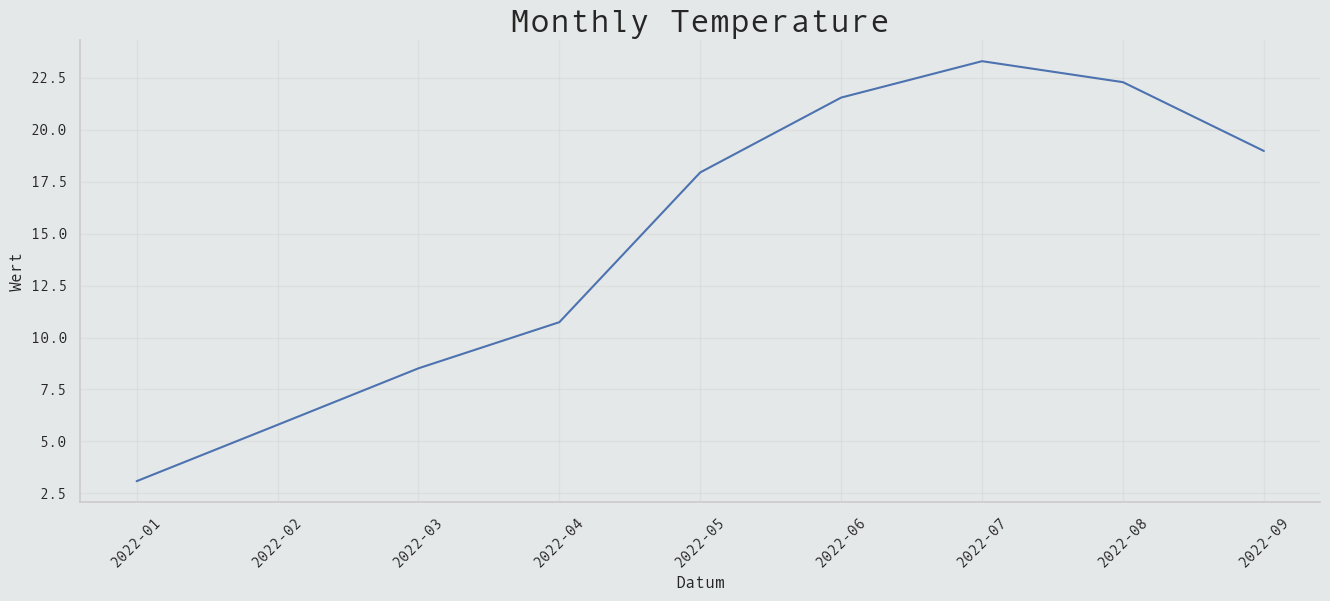

In [43]:
ax = sns.lineplot(
    data=temperatures_2022.groupby([
        temperatures_2022.Datum.dt.strftime('%Y-%m')
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert', 
)

ax.set_title('Monthly Temperature')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

plt.show()

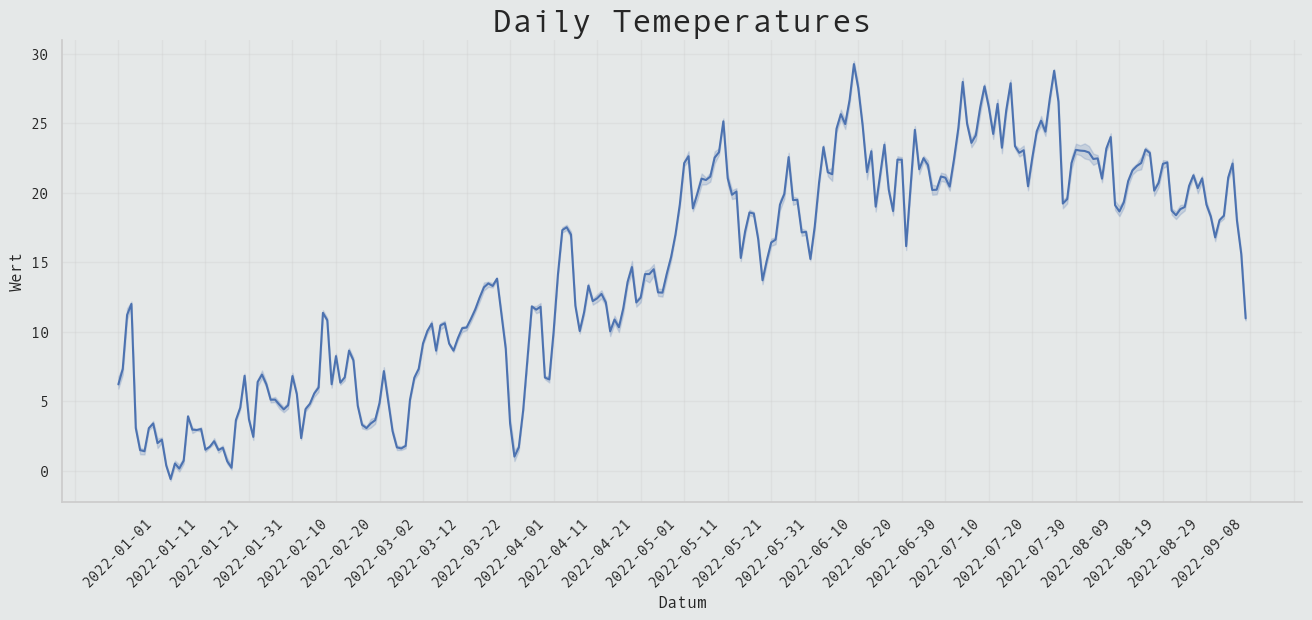

In [47]:
ax = sns.lineplot(
    data=temperatures_2022.groupby([
        temperatures_2022.Datum.dt.strftime('%Y-%m-%d'),
        temperatures_2022.Standort
    ])['Wert'].mean().reset_index(), 
    x='Datum', 
    y='Wert'
)

ax.set_title('Daily Temeperatures')

plt.xticks(rotation=45)

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))

plt.show()

## Daily Precipitations & Temepratures

In [37]:
# Retrieve only precipitations & temperatures
precipitations_temperatures_2022 = weather_2022_data[(weather_2022_data['Parameter'] == 'RainDur') | (weather_2022_data['Parameter'] == 'T')]

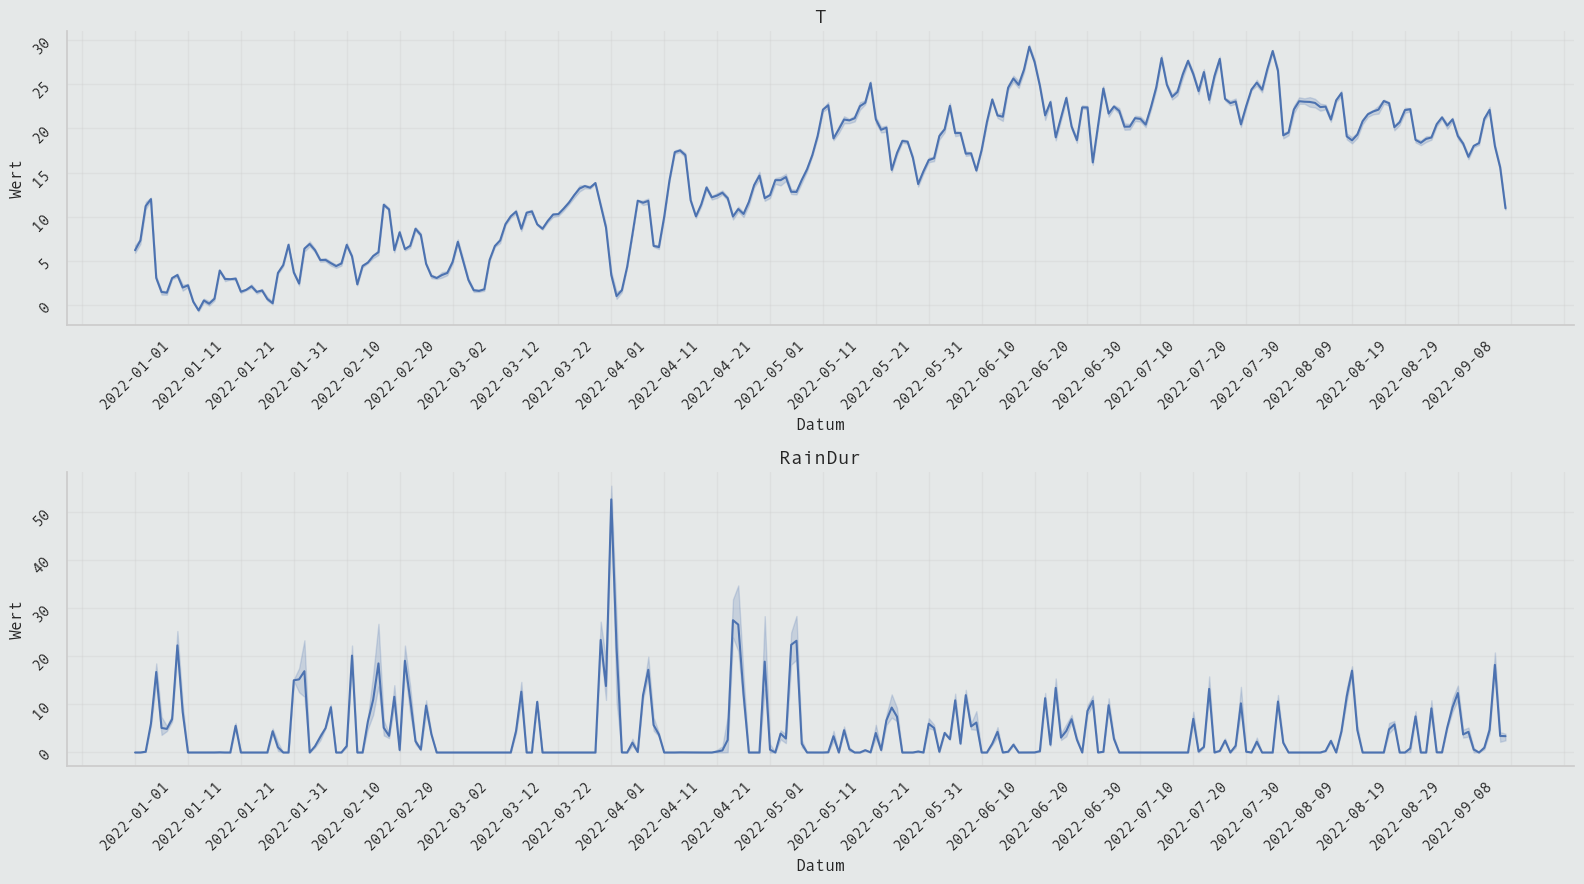

In [55]:
# Define the subplot
figure, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, parameter in enumerate(precipitations_temperatures_2022['Parameter'].unique()):
    
    # Retrieve the data to plot
    data_plot = precipitations_temperatures_2022[precipitations_temperatures_2022['Parameter'] == parameter]
    
    # Define the plot
    sns.lineplot(data=data_plot.groupby([
                        data_plot.Datum.dt.strftime('%Y-%m-%d'), 
                        data_plot.Standort
                        ])['Wert'].mean().reset_index(), 
                 x='Datum', 
                 y='Wert', 
                 ax=ax[index])
    
    # Set the title
    ax[index].set_title(parameter, fontsize=14)
    ax[index].xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
    
    ax[index].tick_params(labelrotation=45)
    
plt.tight_layout()